<h1 align="center">Clustering Russian cities to determines food tastes in different regions</h1>

In [128]:
import pandas as pd
import numpy as np
import re
from geopy.geocoders import Nominatim
import folium
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

<h3> Read table with cities from wikipedia page and leave only names, leave only unique city names</h3>

In [183]:
wikipedia_df = pd.read_html("http://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Russia_by_population")
wikipedia_df=wikipedia_df[0]
columns_to_drop= [wikipedia_df.columns[0],wikipedia_df.columns[2],wikipedia_df.columns[3],wikipedia_df.columns[4],wikipedia_df.columns[5],wikipedia_df.columns[6],wikipedia_df.columns[7],wikipedia_df.columns[8]]
wikipedia_df.drop(columns=columns_to_drop,inplace=True)
wikipedia_df.columns = ["City"]
wikipedia_df.drop_duplicates(subset=['City'], keep='first',inplace=True)
print(wikipedia_df.shape)
wikipedia_df.head()

(322, 1)


,City
0,Moscow
1,Saint Petersburg
2,Novosibirsk
3,Yekaterinburg
4,Kazan


<h2>Get Cities location from Nominatium or pre-build csv and keep it in "cities_loc_df" dataframe</h2>

In [184]:
# geolocator = Nominatim(user_agent="dkaigu@yandex.ru")
# cities_loc_df = pd.DataFrame(columns=["City","Latitude","Longitude"])
# for i in range(323):
#     city=wikipedia_df.City[i]
#     city_query=city+", Russia"
#     city_location = geolocator.geocode(city_query)
#     try:
#         city_latitude = city_location.latitude
#         city_longitude = city_location.longitude
#     except:
#         continue
#     cities_loc_df=cities_loc_df.append({"City":city,"Latitude":city_latitude,"Longitude":city_longitude}, ignore_index=True)
# print("{} latitude, longitude: ({},{})".format(city,city_latitude,city_longitude))
# cities_loc_df.to_csv("rus_cities_loc.csv")
cities_loc_df = pd.read_csv("rus_cities_loc.csv")
cities_loc_df.drop(columns=["Unnamed: 0"],inplace=True)
cities_loc_df.head()

,City,Latitude,Longitude
0,Moscow,55.750446,37.617494
1,Saint Petersburg,59.960674,30.158655
2,Novosibirsk,55.028217,82.923451
3,Yekaterinburg,56.839104,60.608250
4,Kazan,55.782355,49.124227


<h3>We need to replace Saint Petersburg location, bacause it is not in city center</h3>

In [190]:
cities_loc_df.loc[1,"Latitude"]=59.9385
cities_loc_df.loc[1,"Longitude"]=30.3144
cities_loc_df.head()

,City,Latitude,Longitude
0,Moscow,55.750446,37.617494
1,Saint Petersburg,59.938500,30.314400
2,Novosibirsk,55.028217,82.923451
3,Yekaterinburg,56.839104,60.608250
4,Kazan,55.782355,49.124227


<h3> Merge wikipedia_df, cities_loc_df by "City" and create "cities_df" dataframe with cities names and locations</h3>

In [191]:
cities_df = pd.merge(wikipedia_df, cities_loc_df, on=['City'])
cities_df.drop_duplicates(subset=['City'], keep='first',inplace=True)
cities_df.head()

,City,Latitude,Longitude
0,Moscow,55.750446,37.617494
1,Saint Petersburg,59.938500,30.314400
2,Novosibirsk,55.028217,82.923451
3,Yekaterinburg,56.839104,60.608250
4,Kazan,55.782355,49.124227


<h3>Visualize all cities from dataframe on map</h3>

In [194]:
russia_location = geolocator.geocode("Russia")
russia_latitude = russia_location.latitude
russia_longitude = russia_location.longitude

map_russia = folium.Map(location=[russia_latitude, russia_longitude], zoom_start=4)
# add markers to map
for lat, lng, label in zip(cities_df['Latitude'], cities_df['Longitude'], cities_df['City']):
    label = label
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_russia)  

map_russia

<h3>Import credentials from FourSquare account, set "Food" category and define function for getting nearby venues</h3>

In [258]:
CLIENT_ID = 'IBBRPE2XMZ4QHIXN4K01EUFD4WCWJFYHFGOM3J5PJTG2QHWZ' # your Foursquare ID
CLIENT_SECRET = 'I3HUQRLIYM4DJLMLPJBYTL2RSPBDEHLEJMX0CSYV235PYLJQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 5000
categoryId="4d4b7105d754a06374d81259"
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            categoryId, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print("Cannot get correct response for City: ", name)
            continue

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            # v['venue']['id'],
            # getVenueRank(v['venue']['id']), 
            # v['venue']['location']['lat'], 
            # v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City_Latitude', 
                  'City_Longitude', 
                  'Venue', 
                #   'Venue_Id',
                #   'Venue_Rank',
                #   'Venue_Latitude', 
                #   'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IBBRPE2XMZ4QHIXN4K01EUFD4WCWJFYHFGOM3J5PJTG2QHWZ
CLIENT_SECRET:I3HUQRLIYM4DJLMLPJBYTL2RSPBDEHLEJMX0CSYV235PYLJQ


<h3>Now we need to get venues for our cities. It is long process, so we can do it once and store data to csv</h3>

In [259]:
# russia_venues = getNearbyVenues(names=cities_df['City'],
#                                    latitudes=cities_df['Latitude'],
#                                    longitudes=cities_df['Longitude'],
#                                   )
# russia_venues.to_csv("russia_venues.csv")
russia_venues = pd.read_csv("russia_venues.csv")
russia_venues.drop(columns=["Unnamed: 0","Venue_Latitude","Venue_Longitude"],inplace=True)
print(russia_venues.shape)
russia_venues.head()

(10214, 5)


,City,City_Latitude,City_Longitude,Venue,Venue_Category
0,Moscow,55.750446,37.617494,Beluga (Белуга),Russian Restaurant
1,Moscow,55.750446,37.617494,Траппист,Belgian Restaurant
2,Moscow,55.750446,37.617494,Dr. Zhivago (Dr. Zhivago (Dr. Живаго)),Russian Restaurant
3,Moscow,55.750446,37.617494,5642 высота,Caucasian Restaurant
4,Moscow,55.750446,37.617494,Pinzeria by Bontempi,Pizza Place


<h3>Count unique food point categories</h3>

In [218]:
russia_venues.groupby('City').count()
print('There are {} uniques categories.'.format(len(russia_venues['Venue_Category'].unique())))

There are 112 uniques categories.


<h3>Now we need to create dataframe with food point categories</h3>

In [222]:
russia_onehot = pd.get_dummies(russia_venues[['Venue_Category']], prefix="", prefix_sep="")
russia_onehot['City'] = russia_venues['City'] 

# move column to the first column
fixed_columns = [russia_onehot.columns[-1]] + list(russia_onehot.columns[:-1])
russia_onehot = russia_onehot[fixed_columns]

print(russia_onehot.shape)
russia_onehot.head()

(10214, 113)


,City,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,West-Ukrainian Restaurant,Wings Joint,Zhejiang Restaurant
0,Moscow,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Moscow,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Moscow,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Moscow,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Moscow,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3> Group food point categories by City</h3>

In [223]:
russia_grouped = russia_onehot.groupby('City').mean().reset_index()
russia_grouped

,City,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,West-Ukrainian Restaurant,Wings Joint,Zhejiang Restaurant
0,Abakan,0.0,0.000000,0.0,0.0,0.029412,0.0,0.0,0.029412,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.0
1,Achinsk,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Aleksin,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Alexandrov,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,Almetyevsk,0.0,0.000000,0.0,0.0,0.055556,0.0,0.0,0.055556,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Zelenogorsk,0.0,0.000000,0.0,0.0,0.032258,0.0,0.0,0.064516,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
302,Zheleznogorsk,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
303,Zhigulyovsk,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
304,Zhukovsky,0.0,0.054054,0.0,0.0,0.000000,0.0,0.0,0.054054,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


<h3>Lets build dataframe with top 10 common venues in every cities, it helps us to analyse clustering</h3>

In [224]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
russia_venues_sorted = pd.DataFrame(columns=columns)
russia_venues_sorted['City'] = russia_grouped['City']

for ind in np.arange(russia_grouped.shape[0]):
    russia_venues_sorted.iloc[ind, 1:] = return_most_common_venues(russia_grouped.iloc[ind, :], num_top_venues)

russia_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abakan,Café,Burger Joint,Restaurant,Pizza Place,Sushi Restaurant,Bistro,Italian Restaurant,Asian Restaurant,BBQ Joint,Burrito Place
1,Achinsk,Pizza Place,Café,Diner,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant
2,Aleksin,Pizza Place,Café,Restaurant,Italian Restaurant,Bistro,Diner,Grilled Meat Restaurant,Fast Food Restaurant,Doner Restaurant,Indian Restaurant
3,Alexandrov,Japanese Restaurant,Café,Restaurant,Sushi Restaurant,Zhejiang Restaurant,Food,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
4,Almetyevsk,Sushi Restaurant,Restaurant,Eastern European Restaurant,Café,Deli / Bodega,Chinese Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Pizza Place,Asian Restaurant


In [225]:
kclusters = 5

russia_grouped_clustering = russia_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(russia_grouped_clustering)

# check cluster labels generated for each row in the dataframe
# print(type(kmeans.labels_[0]))
kmeans.labels_[0:100]

array([1, 0, 0, 1, 3, 1, 3, 4, 1, 3, 1, 3, 1, 4, 3, 1, 3, 3, 0, 3, 2, 3,
       1, 0, 4, 2, 3, 3, 1, 1, 1, 3, 3, 4, 3, 3, 2, 3, 4, 2, 1, 1, 3, 3,
       1, 3, 1, 4, 1, 3, 2, 0, 3, 3, 1, 0, 3, 1, 3, 3, 1, 2, 3, 1, 3, 0,
       1, 3, 3, 3, 3, 1, 1, 3, 2, 4, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 4, 3,
       3, 3, 3, 2, 3, 3, 2, 1, 1, 0, 4, 1])

In [227]:
try:
    russia_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass
russia_merged = cities_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
russia_merged = pd.merge(russia_merged,russia_venues_sorted, on='City')

# check the last columns!

In [239]:
russia_merged

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Moscow,55.750446,37.617494,3,Caucasian Restaurant,Café,Restaurant,Russian Restaurant,Italian Restaurant,Irish Pub,Pizza Place,Bakery,Steakhouse,Seafood Restaurant
1,Saint Petersburg,59.938500,30.314400,3,Restaurant,Bakery,Caucasian Restaurant,Café,Italian Restaurant,Asian Restaurant,Indian Restaurant,Japanese Restaurant,Modern European Restaurant,Pizza Place
2,Novosibirsk,55.028217,82.923451,3,Restaurant,Café,BBQ Joint,Pizza Place,Middle Eastern Restaurant,Asian Restaurant,Diner,Burger Joint,Italian Restaurant,Sushi Restaurant
3,Yekaterinburg,56.839104,60.608250,3,Restaurant,Bakery,Caucasian Restaurant,Middle Eastern Restaurant,Café,Pizza Place,Italian Restaurant,Fast Food Restaurant,Burger Joint,Eastern European Restaurant
4,Kazan,55.782355,49.124227,3,Café,Restaurant,Fast Food Restaurant,Eastern European Restaurant,Middle Eastern Restaurant,Bakery,Italian Restaurant,Asian Restaurant,Gastropub,American Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Krasnokamensk,50.096992,118.041344,3,Sushi Restaurant,Asian Restaurant,Snack Place,Cafeteria,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant
302,Salekhard,66.537539,66.615747,2,Restaurant,Café,Middle Eastern Restaurant,Food Court,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant
303,Kirishi,59.450325,32.010578,1,Café,Restaurant,Cafeteria,Deli / Bodega,Asian Restaurant,Eastern European Restaurant,Fast Food Restaurant,Fried Chicken Joint,Bistro,Shawarma Place
304,Solnechnogorsk,56.185350,36.978154,3,Restaurant,Sushi Restaurant,Fast Food Restaurant,BBQ Joint,Italian Restaurant,Bistro,Donut Shop,Café,Burger Joint,Diner


<h3>Examining clusters</h3>

In [240]:
russia_merged.loc[russia_merged['Cluster Labels'] == 0, russia_merged.columns[[0] + list(range(3, russia_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Nizhny Tagil,0,Pizza Place,Café,Eastern European Restaurant,Restaurant,Sandwich Place,Bakery,Italian Restaurant,Sushi Restaurant,Food Truck,Japanese Restaurant
69,Sterlitamak,0,Café,Pizza Place,Restaurant,Breakfast Spot,Sushi Restaurant,Eastern European Restaurant,Food Court,Diner,Fast Food Restaurant,Bistro
74,Komsomolsk-on-Amur,0,Pizza Place,Steakhouse,Eastern European Restaurant,Café,Burrito Place,Restaurant,Burger Joint,Fast Food Restaurant,Diner,Doner Restaurant
105,Zlatoust,0,Restaurant,Pizza Place,Café,Sandwich Place,Eastern European Restaurant,Burger Joint,Zhejiang Restaurant,Diner,Doner Restaurant,Donut Shop
122,Neftekamsk,0,Pizza Place,Restaurant,American Restaurant,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant,Cafeteria,Turkish Restaurant,English Restaurant,Falafel Restaurant
132,Novomoskovsk,0,Pizza Place,Restaurant,Eastern European Restaurant,French Restaurant,Caucasian Restaurant,Fast Food Restaurant,Burger Joint,Sushi Restaurant,Japanese Restaurant,German Restaurant
140,Nevinnomyssk,0,Pizza Place,Sushi Restaurant,Restaurant,Snack Place,Italian Restaurant,Hot Dog Joint,Grilled Meat Restaurant,Falafel Restaurant,Dim Sum Restaurant,Diner
143,Dimitrovgrad,0,Pizza Place,Café,Japanese Restaurant,Restaurant,Asian Restaurant,Deli / Bodega,Jewish Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant
154,Achinsk,0,Pizza Place,Café,Diner,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant
161,Novokuybyshevsk,0,Pizza Place,Café,Sushi Restaurant,Japanese Restaurant,Fast Food Restaurant,Zhejiang Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


In [255]:
russia_merged.loc[russia_merged['Cluster Labels'] == 1, russia_merged.columns[[0] + list(range(3, russia_merged.shape[1]))]].head(50)


,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Makhachkala,1,Café,Restaurant,Eastern European Restaurant,Caucasian Restaurant,Italian Restaurant,Burger Joint,Middle Eastern Restaurant,Modern European Restaurant,Asian Restaurant,Pizza Place
31,Kirov,1,Café,Burger Joint,Restaurant,Cafeteria,Sushi Restaurant,Pizza Place,Caucasian Restaurant,Fast Food Restaurant,Gastropub,BBQ Joint
33,Cheboksary,1,Café,Restaurant,Sushi Restaurant,Pizza Place,Fast Food Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Caucasian Restaurant,Steakhouse,Italian Restaurant
39,Ulan-Ude,1,Café,Restaurant,Asian Restaurant,Pizza Place,Mongolian Restaurant,Chinese Restaurant,Snack Place,Burger Joint,Japanese Restaurant,Dumpling Restaurant
43,Sevastopol,1,Café,Restaurant,Sushi Restaurant,Pizza Place,Bakery,BBQ Joint,Seafood Restaurant,Italian Restaurant,Fast Food Restaurant,Steakhouse
53,Smolensk,1,Café,Pizza Place,Fast Food Restaurant,Sushi Restaurant,Restaurant,Japanese Restaurant,Gastropub,German Restaurant,Cafeteria,Modern European Restaurant
59,Vologda,1,Café,Restaurant,Cafeteria,Pizza Place,Italian Restaurant,Fast Food Restaurant,Eastern European Restaurant,Sushi Restaurant,Gastropub,Varenyky restaurant
64,Tambov,1,Café,Restaurant,Pizza Place,Fast Food Restaurant,Diner,Japanese Restaurant,BBQ Joint,Sandwich Place,Gastropub,American Restaurant
68,Kostroma,1,Café,Restaurant,Pizza Place,Eastern European Restaurant,Cafeteria,Bakery,Middle Eastern Restaurant,Sushi Restaurant,Gastropub,Japanese Restaurant
71,Yoshkar-Ola,1,Café,Sushi Restaurant,Japanese Restaurant,American Restaurant,Middle Eastern Restaurant,Irish Pub,Pizza Place,Sandwich Place,Restaurant,Russian Restaurant


In [244]:
russia_merged.loc[russia_merged['Cluster Labels'] == 2, russia_merged.columns[[0] + list(range(3, russia_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
81,Engels,2,Restaurant,Café,Sushi Restaurant,Italian Restaurant,Eastern European Restaurant,Pizza Place,Blini House,Bistro,Fast Food Restaurant,Noodle House
101,Volgodonsk,2,Restaurant,Steakhouse,Japanese Restaurant,Pizza Place,Gastropub,Soup Place,Sushi Restaurant,Café,Caucasian Restaurant,Fast Food Restaurant
102,Novocherkassk,2,Restaurant,Café,Sushi Restaurant,Pizza Place,Sandwich Place,Italian Restaurant,Japanese Restaurant,Gastropub,Fast Food Restaurant,Eastern European Restaurant
124,Bataysk,2,Restaurant,Gastropub,Diner,Sandwich Place,Dumpling Restaurant,Café,Modern European Restaurant,French Restaurant,Sushi Restaurant,BBQ Joint
129,Derbent,2,Restaurant,Eastern European Restaurant,Food,Middle Eastern Restaurant,Food Court,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,English Restaurant
157,Noginsk,2,Restaurant,Fast Food Restaurant,Eastern European Restaurant,Snack Place,BBQ Joint,German Restaurant,Sandwich Place,Cafeteria,Donut Shop,Czech Restaurant
160,Khanty-Mansiysk,2,Restaurant,Sushi Restaurant,Fast Food Restaurant,Eastern European Restaurant,Café,Italian Restaurant,Irish Pub,Sandwich Place,Dim Sum Restaurant,Diner
170,Mikhaylovsk,2,Restaurant,Snack Place,Russian Restaurant,Fish & Chips Shop,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
172,Leninsk-Kuznetsky,2,Restaurant,Eastern European Restaurant,Café,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,English Restaurant,Ethiopian Restaurant
177,Magadan,2,Restaurant,Café,Snack Place,Steakhouse,Blini House,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,Hot Dog Joint,Gastropub


In [254]:
russia_merged.loc[russia_merged['Cluster Labels'] == 3, russia_merged.columns[[0] + list(range(3, russia_merged.shape[1]))]].head(20)

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Moscow,3,Caucasian Restaurant,Café,Restaurant,Russian Restaurant,Italian Restaurant,Irish Pub,Pizza Place,Bakery,Steakhouse,Seafood Restaurant
1,Saint Petersburg,3,Restaurant,Bakery,Caucasian Restaurant,Café,Italian Restaurant,Asian Restaurant,Indian Restaurant,Japanese Restaurant,Modern European Restaurant,Pizza Place
2,Novosibirsk,3,Restaurant,Café,BBQ Joint,Pizza Place,Middle Eastern Restaurant,Asian Restaurant,Diner,Burger Joint,Italian Restaurant,Sushi Restaurant
3,Yekaterinburg,3,Restaurant,Bakery,Caucasian Restaurant,Middle Eastern Restaurant,Café,Pizza Place,Italian Restaurant,Fast Food Restaurant,Burger Joint,Eastern European Restaurant
4,Kazan,3,Café,Restaurant,Fast Food Restaurant,Eastern European Restaurant,Middle Eastern Restaurant,Bakery,Italian Restaurant,Asian Restaurant,Gastropub,American Restaurant
5,Nizhny Novgorod,3,Café,Caucasian Restaurant,Restaurant,Italian Restaurant,Steakhouse,Fast Food Restaurant,Bakery,Middle Eastern Restaurant,Pizza Place,Burger Joint
6,Chelyabinsk,3,Restaurant,Café,Pizza Place,Pelmeni House,Italian Restaurant,Gastropub,Caucasian Restaurant,BBQ Joint,Middle Eastern Restaurant,Asian Restaurant
7,Samara,3,Café,Restaurant,Italian Restaurant,Caucasian Restaurant,Eastern European Restaurant,BBQ Joint,Bakery,Pizza Place,Middle Eastern Restaurant,Snack Place
8,Omsk,3,Restaurant,Café,Fast Food Restaurant,Eastern European Restaurant,BBQ Joint,Pizza Place,Noodle House,Italian Restaurant,Bakery,Sushi Restaurant
9,Rostov-on-Don,3,Restaurant,Café,Italian Restaurant,German Restaurant,Gastropub,Fast Food Restaurant,Steakhouse,Asian Restaurant,Pizza Place,Eastern European Restaurant


In [241]:
russia_merged.loc[russia_merged['Cluster Labels'] == 4, russia_merged.columns[[0] + list(range(3, russia_merged.shape[1]))]]

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,Kurgan,4,Café,Zhejiang Restaurant,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
91,Prokopyevsk,4,Café,Japanese Restaurant,Zhejiang Restaurant,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant
133,Nazran,4,Café,Pizza Place,Eastern European Restaurant,Zhejiang Restaurant,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,English Restaurant,Ethiopian Restaurant
136,Kyzyl,4,Café,Diner,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
151,Novoshakhtinsk,4,Sushi Restaurant,Café,Zhejiang Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant
168,Sarov,4,Café,Pizza Place,Restaurant,Italian Restaurant,Hawaiian Restaurant,Fast Food Restaurant,Diner,Doner Restaurant,Indian Restaurant,Donut Shop
182,Kansk,4,Café,Sushi Restaurant,Restaurant,Zhejiang Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant
185,Kiselyovsk,4,Café,Zhejiang Restaurant,Sushi Restaurant,Diner,Salad Place,Asian Restaurant,Australian Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant
194,Yurga,4,Café,Sushi Restaurant,Pizza Place,Eastern European Restaurant,BBQ Joint,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,English Restaurant
195,Kuznetsk,4,Café,Sushi Restaurant,Japanese Restaurant,Pizza Place,Zhejiang Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant


<h3>Lets visualize clusters popularity</h3>

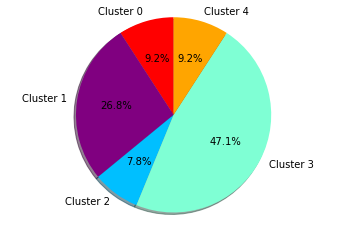

In [253]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

colors = ['red', 'purple', 'deepskyblue', 'aquamarine', 'orange']
clusters_dict ={}
for i in range(len(kmeans.labels_)):
    clusters_dict[kmeans.labels_[i]]=clusters_dict.get(kmeans.labels_[i],0)+1
# print(clusters_dict)
# print(len(kmeans.labels_))
for i in range(len(clusters_dict)):
    clusters_dict[i] = (clusters_dict[i]/len(kmeans.labels_))*100
# print(clusters_dict)
labels = ['Cluster '+str(i) for i in range(len(clusters_dict))]
sizes = [clusters_dict[i] for i in range(len(clusters_dict))]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<h3>Let's visualize clusters on the map</h3>

In [237]:
# create map
map_clusters = folium.Map(location=[russia_latitude, russia_longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(russia_merged['Latitude'], russia_merged['Longitude'], russia_merged['City'], russia_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters